#Problem Statement :
Given a set of images captured in grocery stores(shelf image), and a set of close up images of products in
those stores, your task is as follows.
1. For every product image, find the location of that product in all shelf images in which it appears.
2. For every shelf image, locate all products and assign the name from given set of product images.

#Approach : 
1. For Object Detection I have used Yolov4-P5.

2. The next part is product matching, where I trained a classification model using transfer learning on Resnet50V2 trained on 'imagenet'.

3. Fine-tuning of the model.

4. Used data augmentations.

5. The train, test split used is in ratio 0.1665.

6. Trained the model for 10 epochs.

7. After detecting, I traversed through each bounding box, cropped those out and passed it to the model. The classifier then predicted the product id out of it.

8. Finally saved the results in the respected solution text files.

**Install dependencies**

In [ ]:
!pip install --upgrade imgaug
!pip install imagecorruptions

     |████████████████████████████████| 948 kB 30.5 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.
     |████████████████████████████████| 2.1 MB 27.9 MB/s 


**Download the product dataset zipfile**

In [ ]:
!wget https://storage.googleapis.com/open_source_datasets/product_detection_from_packshots.tar.gz

--2022-04-20 16:50:25--  https://storage.googleapis.com/open_source_datasets/product_detection_from_packshots.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.111.128, 172.217.164.144, 142.251.16.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947415270 (904M) [application/gzip]
Saving to: ‘product_detection_from_packshots.tar.gz’

product_detection_f 100%[===================>] 903.53M   119MB/s    in 6.9s    

2022-04-20 16:50:32 (131 MB/s) - ‘product_detection_from_packshots.tar.gz’ saved [947415270/947415270]



**Unzip the dataset**

In [ ]:
import shutil
shutil.unpack_archive("product_detection_from_packshots.tar.gz", "/content")

## **Import Dependencies**

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
import imgaug.augmenters as iaa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from natsort import natsorted
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tqdm import tqdm

**Mount the drive**

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


## **Data Preparation**


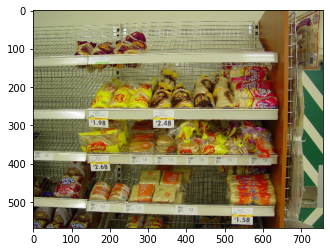

In [ ]:
shelf_img_path = '/content/product_detection_from_packshots/shelf_images/db1.jpg'
plt.imshow(plt.imread(shelf_img_path))

## **Object Detection using Yolov4**

Using the pretrained model from roboflow

**Prepare yolov4 environment**

In [ ]:
!pwd

/content


In [ ]:
!git clone https://github.com/roboflow-ai/ScaledYOLOv4.git 
%cd /content/ScaledYOLOv4
!git checkout yolov4-large

Cloning into 'ScaledYOLOv4'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 389.37 KiB | 25.96 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/ScaledYOLOv4
Branch 'yolov4-large' set up to track remote branch 'yolov4-large' from 'origin'.
Switched to a new branch 'yolov4-large'


In [ ]:
%cd /content/
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!python setup.py build install

/content
Cloning into 'mish-cuda'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 195 (delta 7), reused 79 (delta 3), pack-reused 107
Receiving objects: 100% (195/195), 208.77 KiB | 18.98 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/mish-cuda
/usr/lib/python3.7/distutils/extension.py:131: UserWarning: Unknown Extension options: 'headers'
  warnings.warn(msg)
running build
running build_py
creating build
creating build/lib.linux-x86_64-3.7
creating build/lib.linux-x86_64-3.7/mish_cuda
copying src/mish_cuda/__init__.py -> build/lib.linux-x86_64-3.7/mish_cuda
running egg_info
creating src/mish_cuda.egg-info
writing src/mish_cuda.egg-info/PKG-INFO
writing dependency_links to src/mish_cuda.egg-info/dependency_links.txt
writing requirements to src/mish_cuda.egg-info/requires.txt
writing top-level names to src/mish_cuda.egg-info/top_level.txt
writing manifest file 'src/mish_c

In [ ]:
!pip install -U PyYAML

     |████████████████████████████████| 596 kB 30.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


**Store the detected results**

In [ ]:
!python /content/ScaledYOLOv4/detect.py --weights /content/drive/MyDrive/weights/last_yolov4-p5-results_strip.pt --source /content/product_detection_from_packshots/shelf_images --output /content/drive/MyDrive/detected_shelf_objects --img-size 896 --save-txt

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=896, iou_thres=0.5, output='/content/drive/MyDrive/detected_shelf_objects', save_txt=True, source='/content/product_detection_from_packshots/shelf_images', update=False, view_img=False, weights=['/content/drive/MyDrive/weights/last_yolov4-p5-results_strip.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15109MB)

Fusing layers... Model Summary: 331 layers, 7.02988e+07 parameters, 6.81919e+07 gradients
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
image 1/3153 /content/product_detection_from_packshots/shelf_images/db1.jpg: 768x896 Done. (0.075s)
image 2/3153 /content/product_detection_from_packshots/shelf

## **Define the classification task**


In [ ]:
from natsort import natsorted
import os

**Load product images**

In [ ]:
product_path = '/content/product_detection_from_packshots/product_images'
img_list = natsorted(os.listdir(product_path))
print(img_list)

['qr1.jpg', 'qr2.jpg', 'qr3.jpg', 'qr4.jpg', 'qr5.jpg', 'qr6.jpg', 'qr7.jpg', 'qr8.jpg', 'qr9.jpg', 'qr10.jpg', 'qr11.jpg', 'qr12.jpg', 'qr13.jpg', 'qr14.jpg', 'qr15.jpg', 'qr16.jpg', 'qr17.jpg', 'qr18.jpg', 'qr19.jpg', 'qr20.jpg', 'qr21.jpg', 'qr22.jpg', 'qr23.jpg', 'qr24.jpg', 'qr25.jpg', 'qr26.jpg', 'qr27.jpg', 'qr28.jpg', 'qr29.jpg', 'qr30.jpg', 'qr31.jpg', 'qr32.jpg', 'qr33.jpg', 'qr34.jpg', 'qr35.jpg', 'qr36.jpg', 'qr37.jpg', 'qr38.jpg', 'qr39.jpg', 'qr40.jpg', 'qr41.jpg', 'qr42.jpg', 'qr43.jpg', 'qr44.jpg', 'qr45.jpg', 'qr46.jpg', 'qr47.jpg', 'qr48.jpg', 'qr49.jpg', 'qr50.jpg', 'qr51.jpg', 'qr52.jpg', 'qr53.jpg', 'qr54.jpg', 'qr55.jpg', 'qr56.jpg', 'qr57.jpg', 'qr58.jpg', 'qr59.jpg', 'qr60.jpg', 'qr61.jpg', 'qr62.jpg', 'qr63.jpg', 'qr64.jpg', 'qr65.jpg', 'qr66.jpg', 'qr67.jpg', 'qr68.jpg', 'qr69.jpg', 'qr70.jpg', 'qr71.jpg', 'qr72.jpg', 'qr73.jpg', 'qr74.jpg', 'qr75.jpg', 'qr76.jpg', 'qr77.jpg', 'qr78.jpg', 'qr79.jpg', 'qr80.jpg', 'qr81.jpg', 'qr82.jpg', 'qr83.jpg', 'qr84.jpg', 

In [ ]:
class_labels = [i for i in range(0,100)]
img_name = img_list[0]
cls_id = 0
img_df = pd.DataFrame(columns = ['img_path', 'cls_id'])
for img_id, img in enumerate(img_list):
  img_path = os.path.join(product_path, img)
  id = (int(img.split('.')[0].split('qr')[1]))
  if (id-1)!=0 and (id-1)%3==0:
    cls_id+=1
    img_df.loc[img_id, 'img_path'] = img_path
    img_df.loc[img_id, 'cls_id'] = str(class_labels[cls_id])

  else:
    img_df.loc[img_id, 'img_path'] = img_path
    img_df.loc[img_id, 'cls_id'] = str(class_labels[cls_id])
    
img_df

img_path cls_id
0    /content/product_detection_from_packshots/prod...      0
1    /content/product_detection_from_packshots/prod...      0
2    /content/product_detection_from_packshots/prod...      0
3    /content/product_detection_from_packshots/prod...      1
4    /content/product_detection_from_packshots/prod...      1
..                                                 ...    ...
295  /content/product_detection_from_packshots/prod...     98
296  /content/product_detection_from_packshots/prod...     98
297  /content/product_detection_from_packshots/prod...     99
298  /content/product_detection_from_packshots/prod...     99
299  /content/product_detection_from_packshots/prod...     99

[300 rows x 2 columns]

In [ ]:
img_list = []
labels_list = []

(w,h) = (1200,1200)
for img_id_, path in enumerate(img_df['img_path']):
  img_ = plt.imread(path)
  center = [el/2 for el in img_.shape[:2]]

  x = center[1] - w/2
  y = center[0] - h/2
  img_ = img_[int(y):int(y+h), int(x):int(x+w)]
  img_ = tf.keras.preprocessing.image.smart_resize(img_, size = (256,256), interpolation='bicubic')

  img_-=img_.min()
  img_/=(img_.max()-img_.min())

  img_list.append(img_)
  labels_list.append(img_df['cls_id'][img_id_])

**Visualize images**

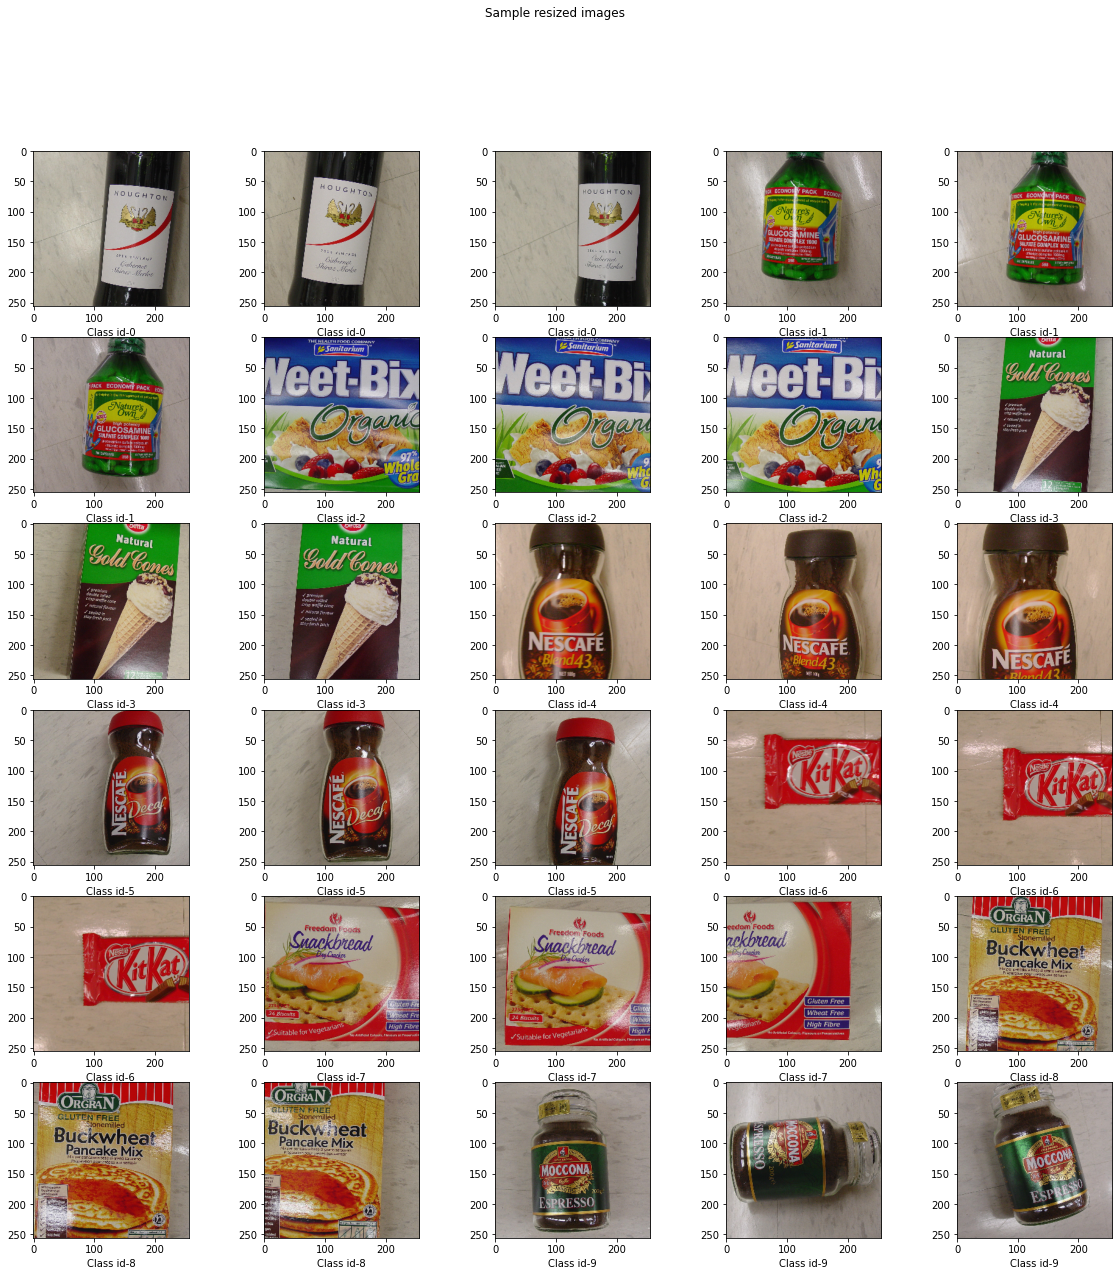

In [ ]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Sample resized images')
for i in range(30):
  fig.add_subplot(6,5,i+1)
  plt.imshow(img_list[i])
  plt.xlabel(f'Class id-{labels_list[i]}')

In [ ]:
img_array = np.array(img_list, dtype = np.float32)
label_array = np.array(labels_list, dtype = np.int32)

print(f'Dataset shape {img_array.shape, label_array.shape}')
print(f'Dataset dtype {img_array.dtype, label_array.dtype}')

Dataset shape ((300, 256, 256, 3), (300,))
Dataset dtype (dtype('float32'), dtype('int32'))


**Define data augmentation functions on the dataset**

For data augmentation we use image-augmentor module.

In [ ]:
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    new_img
    return new_img

def img_aug(dataset,label, class_idx = 0):

  idx_list = [i for i,j in enumerate(label) if j==class_idx]

  auto_contrast = iaa.pillike.Autocontrast()

  auto_brightness = iaa.imgcorruptlike.Brightness()

  sharpness = iaa.pillike.EnhanceSharpness()

  rotate = iaa.Rotate(rotate = (-10,10), order=1)
  eq = iaa.pillike.Equalize()
  ec = iaa.pillike.EnhanceColor()

  img_list = list(dataset)

  aug_list = img_list

  aug_label_list = list(label)
  
  for idx in idx_list:
    img = img_list[idx]
    
    img_con = convert(img,0,255,np.uint8)
    img_con = auto_contrast.augment_image(img_con)
    img_con = convert(img_con,0,1,np.float32)
    aug_list.append(img_con)
    aug_label_list.append(class_idx)
    
    img_b = convert(img,0,255,np.uint8)
    img_b = auto_brightness.augment_image(img_b)
    img_b = convert(img_b,0,1,np.float32)
    aug_list.append(img_b)
    aug_label_list.append(class_idx)

    img_s = convert(img,0,255,np.uint8)
    img_s = sharpness.augment_image(img_s)
    img_s = convert(img_s,0,1,np.float32)
    aug_list.append(img_s)
    aug_label_list.append(class_idx)

    img_eq = convert(img,0,255,np.uint8)
    img_eq = eq.augment_image(img_eq)
    img_eq = convert(img_eq,0,1,np.float32)
    aug_list.append(img_eq)
    aug_label_list.append(class_idx)

    img_ec = convert(img,0,255,np.uint8)
    img_ec = ec.augment_image(img_ec)
    img_ec = convert(img_ec,0,1,np.float32)
    aug_list.append(img_ec)
    aug_label_list.append(class_idx)

    img_r = convert(img,0,255,np.uint8)
    img_r = rotate.augment_image(img_r)
    img_r = convert(img_r,0,1,np.float32)
    aug_list.append(img_r)
    aug_label_list.append(class_idx)

    img_con = convert(img_r,0,255,np.uint8)
    img_con = auto_contrast.augment_image(img_con)
    img_con = convert(img_con,0,1,np.float32)
    aug_list.append(img_con)
    aug_label_list.append(class_idx)
    
    img_b = convert(img_r,0,255,np.uint8)
    img_b = auto_brightness.augment_image(img_b)
    img_b = convert(img_b,0,1,np.float32)
    aug_list.append(img_b)
    aug_label_list.append(class_idx)

    img_s = convert(img_r,0,255,np.uint8)
    img_s = sharpness.augment_image(img_s)
    img_s = convert(img_s,0,1,np.float32)
    aug_list.append(img_s)
    aug_label_list.append(class_idx)

    img_eq = convert(img_r,0,255,np.uint8)
    img_eq = eq.augment_image(img_eq)
    img_eq = convert(img_eq,0,1,np.float32)
    aug_list.append(img_eq)
    aug_label_list.append(class_idx)

    img_ec = convert(img_r,0,255,np.uint8)
    img_ec = ec.augment_image(img_ec)
    img_ec = convert(img_ec,0,1,np.float32)
    aug_list.append(img_ec)
    aug_label_list.append(class_idx)

  aug_img_array = np.array(aug_list, dtype=np.float32)
  aug_img_array = aug_img_array - aug_img_array.min()
  aug_label_list_array = np.array(aug_label_list, dtype=np.int32) 
  
  assert aug_img_array.shape[0] == aug_label_list_array.shape[0]
  
  return aug_img_array, aug_label_list_array

**Apply Data Augmentation**

In [ ]:
for cls in class_labels:
  if cls==0:
    aug_img, aug_label = img_aug(img_array, label_array, class_idx=cls)
  else:
    aug_img, aug_label = img_aug(aug_img, aug_label, class_idx=cls)

In [ ]:
print(f'Augmented Dataset shape {aug_img.shape, aug_label.shape}')
print(f'Augmented dtype {aug_img.dtype, aug_label.dtype}')

Augmented Dataset shape ((3600, 256, 256, 3), (3600,))
Augmented dtype (dtype('float32'), dtype('int32'))


**Class-wise distribution**

In [ ]:
print(f'Total images correponding to individual categories after augmentation {list(aug_label).count(0)}')

Total images correponding to individual categories after augmentation 36


**Visualize augmented samples**


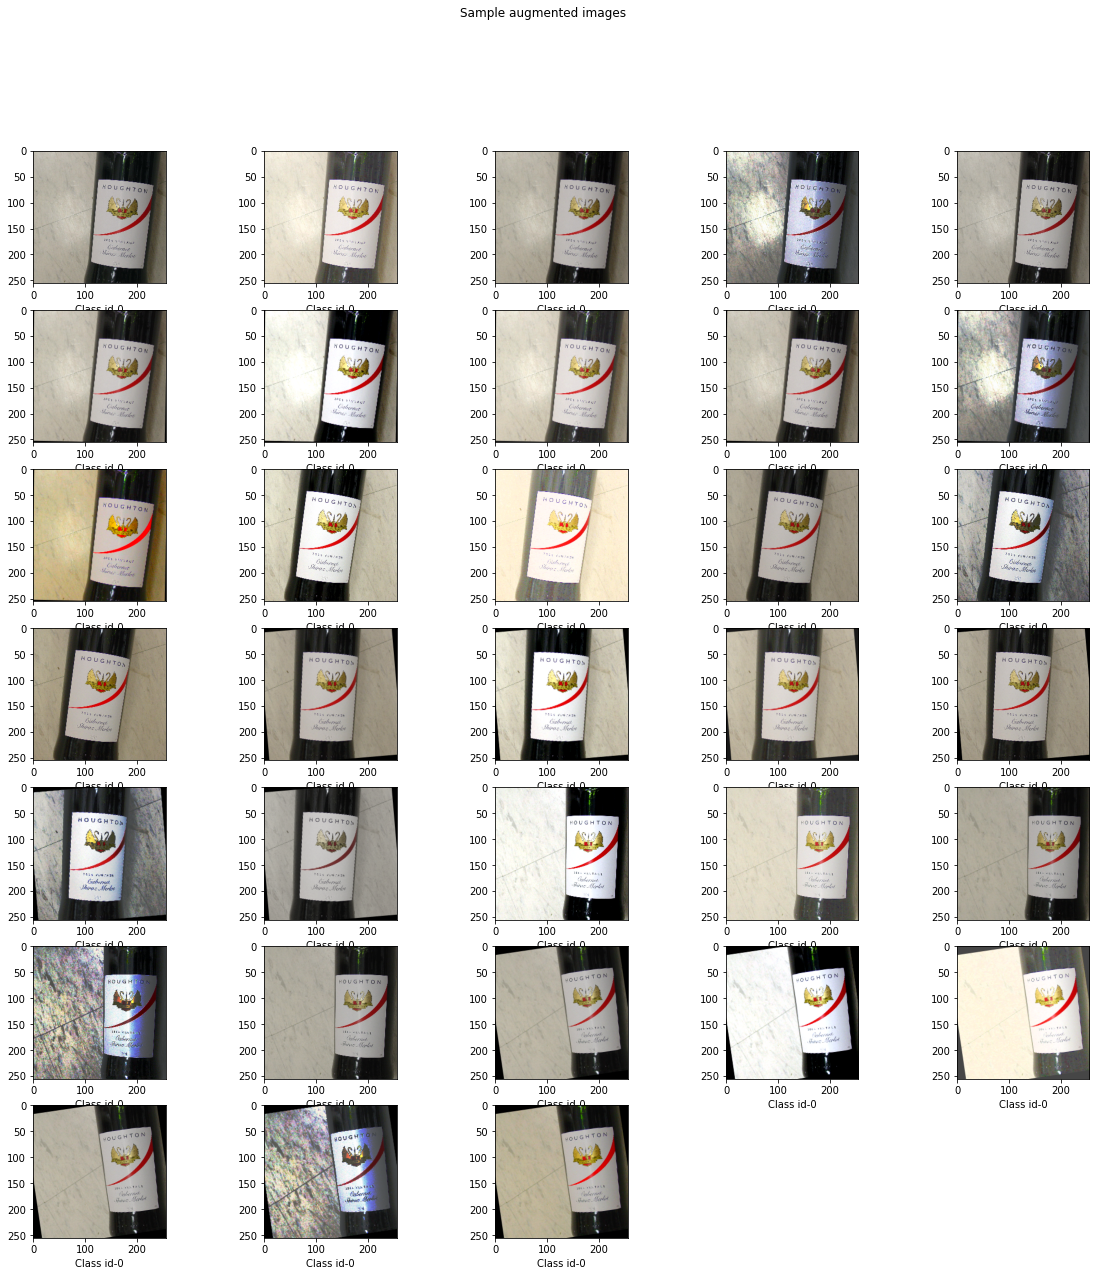

In [ ]:
fig = plt.figure(figsize=(20,20))
fig.suptitle('Sample augmented images')
for i in range(33):
  fig.add_subplot(7,5,i+1)
  plt.imshow(aug_img[300+i])
  plt.xlabel(f'Class id-{aug_label[300+i]}')

**Train test split**

In [ ]:
train_img, valid_main_img, train_label, valid_main_label = train_test_split(aug_img,
                                                                  aug_label,
                                                                  stratify = aug_label,
                                                                  test_size = 0.1665,
                                                                  shuffle = True,
                                                                  random_state = 42) 

valid_img, test_img, valid_label, test_label = train_test_split(valid_main_img,
                                                                  valid_main_label,
                                                                  stratify = valid_main_label,
                                                                  test_size = 0.5,
                                                                  shuffle = True,
                                                                  random_state = 42) 

In [ ]:
print(f'Train set dimension and datatype {train_img.shape, train_img.dtype, train_label.shape, train_label.dtype}')
print(f'Validation set dimension {valid_img.shape, valid_img.dtype, valid_label.shape, valid_label.dtype}')
print(f'Test set dimension and datatype {test_img.shape, test_img.dtype, test_label.shape, test_label.dtype}')

Train set dimension and datatype ((3000, 256, 256, 3), dtype('float32'), (3000,), dtype('int32'))
Validation set dimension ((300, 256, 256, 3), dtype('float32'), (300,), dtype('int32'))
Test set dimension and datatype ((300, 256, 256, 3), dtype('float32'), (300,), dtype('int32'))


## **Model Building**

In [ ]:
def create_resnet50v2_model():
  conv_base = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(256, 256, 3),
    pooling='avg'
  )
  
  model = Sequential()
  model.add(conv_base)
  model.add(Dense(100, activation='softmax'))

  return model

In [ ]:
model = create_resnet50v2_model()

94683136/94668760 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
Total params: 23,769,700
Trainable params: 23,724,260
Non-trainable params: 45,440
_________________________________________________________________


**Define fine-tuning parameters**

In [ ]:
def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

In [ ]:
conv_base = model.get_layer('resnet50v2')

freeze_model(conv_base)
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 100)               204900    
                                                                 
Total params: 23,769,700
Trainable params: 204,900
Non-trainable params: 23,564,800
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## **Model Training**

In [ ]:
def plot_accuracy_curves(history):  
  acc = history.history['acc']
  val_acc = history.history['val_acc']
 
  epochs = range(1, len(acc) + 1)
 
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

def plot_loss_curves(history): 

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()
  
def plot_curves(history): 
  plt.figure(figsize=(18,6))
  plt.subplot(1,2,1)
  plot_accuracy_curves(history)
  plt.subplot(1,2,2)
  plot_loss_curves(history)

**Model compile**

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Define callbacks**

In [ ]:
mc_filepath = os.path.join('/content/drive/MyDrive', 'product_best_model.h5')
mcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=mc_filepath, monitor='val_loss',verbose = 1, save_best_only=True, save_freq=375, mode ='min')

**Train the model**

In [ ]:
history = model.fit(x = train_img, y = train_label, batch_size= 16, epochs = 10, verbose=1, validation_data=(valid_img, valid_label), callbacks=[mcheckpoint])

Epoch 1/10
188/188 [==============================] - 32s 84ms/step - loss: 1.0373 - acc: 0.8437 - val_loss: 0.1008 - val_acc: 0.9967
Epoch 2/10
188/188 [==============================] - 13s 68ms/step - loss: 0.0396 - acc: 1.0000 - val_loss: 0.0514 - val_acc: 0.9967
Epoch 3/10
188/188 [==============================] - 13s 69ms/step - loss: 0.0177 - acc: 1.0000 - val_loss: 0.0375 - val_acc: 0.9967
Epoch 4/10
188/188 [==============================] - 13s 69ms/step - loss: 0.0104 - acc: 1.0000 - val_loss: 0.0314 - val_acc: 0.9967
Epoch 5/10
188/188 [==============================] - 13s 70ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.0276 - val_acc: 0.9967
Epoch 6/10
188/188 [==============================] - 13s 71ms/step - loss: 0.0050 - acc: 1.0000 - val_loss: 0.0240 - val_acc: 0.9967
Epoch 7/10
188/188 [==============================] - 13s 70ms/step - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0228 - val_acc: 0.9967
Epoch 8/10
188/188 [==============================] - 13s 69ms

**Plot training performance**

In [ ]:
model.save('/content/drive/MyDrive/product_best_model.h5')

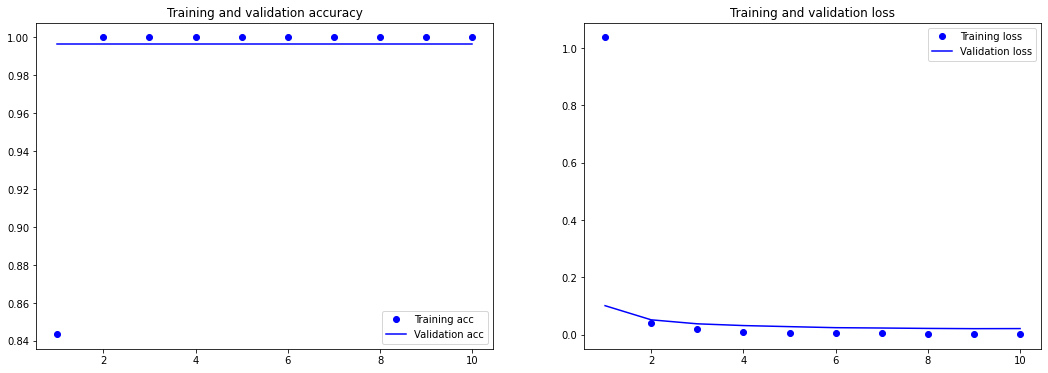

In [ ]:
plot_curves(history)

#### **Evaluate the model training**

In [ ]:
model.evaluate(test_img, test_label)

**Model testing**

In [ ]:
test_pred = model.predict(test_img)
test_pred = np.argmax(test_pred, 1)
print(test_pred)

[32 84 93 50 44 94 17 99 63 46 53 89 96 84 10  5 52 90 56 16 47 88 70 74
 90 88  8 87 66 64 89 24 23 91 69 75  9 71 19 13 30 27 79 98 79 72 76 85
 37 88 11 25 36 54 33 19 52 38 25 80 46 21 46 50  0 29 28  7 29  3 16 60
 43 38  3 12 54 44 57 62 80 69  6  6 55 34 42 72 51 82 61 45 47 95 33 55
 18 74 93 77 35 26 52 41 72 27 91 45 39 42 62 49 13 10 54 71  2 18  7 80
 41 40 20 90 65  1 92 95 70 73 10 65 49 19 21 63 92 33 13 27 61 62 58 68
 73 56 48 58 22 94 22 67  4 48 77 14 92 28  5 96 59 39  4 57 12  5 91 81
 81  0  2 81 60 77 97 36 43 67  9  4 65 42 66 59 32 37 78 70 11 66 86 71
 15 20 35 31 18 40 15  8 24 75 14 99 58 85 15 29  3 97 99 23 49  7 74 56
 30 69  1  6 48 87 40 20 59 53 30 51 76 31 64  8 85 93 34 43  2 47 94 87
 96 26 60 50 36 38 67 79 14 78 41 98 64 17  1 97 22 61 45 44 26 98 35 82
  9 55 82 32 75 83 63 34 24 21 76 68 84 37 83 73 78 17 89 86 39 53 83 51
 12 23 31 11 95 86 68 57 16  0 25 28]


Classification report               precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3
     

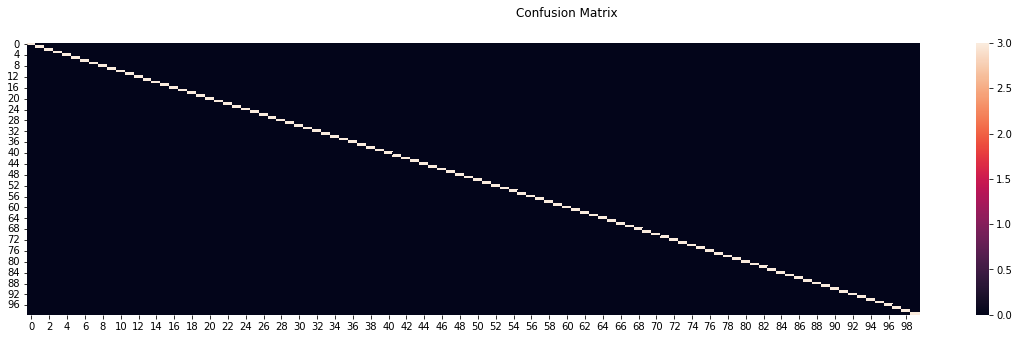

In [ ]:
print(f'Classification report {metrics.classification_report(test_label, test_pred)}')

fig_cm = plt.figure(figsize=(20,5))
fig_cm.suptitle('Confusion Matrix')
sns.heatmap(confusion_matrix(test_label, test_pred))

## **Detect products from shelfs**

In [ ]:
txt_path = '/content/drive/MyDrive/detected_shelf_objects'
txt_files = [file_ for file_ in natsorted(os.listdir(txt_path)) if file_.endswith('.txt')]
img_path = '/content/product_detection_from_packshots/shelf_images'
img_files = [file_ for file_ in natsorted(os.listdir(img_path)) if file_.endswith('.jpg')]


In [ ]:
print(f'Total detected text files available - {len(txt_files)}')
print(f'Total img files files available - {len(img_files)}')

Total detected text files available - 2481
Total img files files available - 3153


**Load the classification model**


In [ ]:
weight_file = '/content/drive/MyDrive/product_best_model.h5'
model.load_weights(weight_file)

In [ ]:
def form_line(id1, id2, x_min, y_min, x_max, y_max):
  line = str(id1)+', '+str(id2)+', '+str(x_min)+', '+str(y_min)+', '+str(x_max)+', '+str(y_max)+ '\n'
  return line

**Detect products from shelf**

In [ ]:
lines_1 = ''
lines_2 = ''

for txt in tqdm(txt_files):
  id = txt.split('.txt')[0]
  demo_txt = os.path.join(txt_path, txt_files[1])
  demo_img = os.path.join(img_path, id+'.jpg')
  
  img_shape = np.flip(np.array(plt.imread(demo_img).shape[:2]))

  img = plt.imread(demo_img)

  with open(demo_txt, 'r') as demo:
    for line in demo.readlines():
      (x_,y_,w_,h_) = line.split()[1:]
      x = int(float(x_)*float(img_shape[0]))
      y = int(float(y_)*float(img_shape[1]))
      w = int(float(w_)*float(img_shape[0]))
      h = int(float(h_)*float(img_shape[1]))
      
      x1 = int(x - (w/2))
      y1 = int(y - (h/2))

      img_ = np.array(img[y1:y1+h, x1:x1+w])

      img_res = tf.keras.preprocessing.image.smart_resize(img_, size = (256,256), interpolation='bicubic')
      img_res = img_res - img_res.min()
      img_res = img_res/(img_res.max() - img_res.min())
      img_res = np.expand_dims(img_res, axis = 0)
      
      y_pred = model.predict(img_res)
      y_pred = np.argmax(y_pred, 1)
      
      x_min = x1
      y_min = y1
      x_max = x1 + w
      y_max = y1 + h
      
      id_key = id.split('db')[1] 
     
      lines_1 += form_line(y_pred[0], id_key, x_min, y_min, x_max, y_max)

      lines_2 += form_line(id_key, y_pred[0], x_min, y_min, x_max, y_max)
    

100%|██████████| 2481/2481 [16:19<00:00,  2.53it/s]


In [ ]:
soln_1_path = os.path.join('/content/drive/MyDrive','solution_1.txt')
if not os.path.isfile(soln_1_path):
  f_1 = open(soln_1_path, 'x')
  f_1.close()

with open(soln_1_path, 'w') as s1:
  s1.write(lines_1)

In [ ]:
soln_2_path = os.path.join('/content/drive/MyDrive','solution_2.txt')
if not os.path.isfile(soln_2_path):
  f_2 = open(soln_2_path, 'x')
  f_2.close()

with open(soln_2_path, 'w') as s2:
  s2.write(lines_2)